
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

pcam, pcam_info = tfds.load('patch_camelyon', shuffle_files=True, with_info=True,
                            data_dir='/content/drive/My Drive/Colab Notebooks')
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [0]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(128).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint_cb = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

In [27]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=20, steps_per_epoch=2048, validation_steps=256)

Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.60467, saving model to best_model.h5
2048/2048 - 349s - loss: 0.1827 - accuracy: 0.9342 - val_loss: 0.6047 - val_accuracy: 0.8145
Epoch 2/20

Epoch 00002: val_loss improved from 0.60467 to 0.35487, saving model to best_model.h5
2048/2048 - 333s - loss: 0.0896 - accuracy: 0.9694 - val_loss: 0.3549 - val_accuracy: 0.8781
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.35487
2048/2048 - 339s - loss: 0.0606 - accuracy: 0.9794 - val_loss: 0.4032 - val_accuracy: 0.8775
Epoch 4/20

Epoch 00004: val_loss did not improve from 0.35487
2048/2048 - 334s - loss: 0.0404 - accuracy: 0.9859 - val_loss: 0.5350 - val_accuracy: 0.8589
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.35487
2048/2048 - 342s - loss: 0.0293 - accuracy: 0.9898 - val_loss: 1.4176 - val_accuracy: 0.7930
Epoch 6/20

Epoch 00006: val_loss did not improve from 0.35487
2048/2048 - 333s - loss: 0.0240 - accuracy: 0.9915 - val_loss: 0.8310 - val_accuracy: 0.835

In [28]:
best_model = load_model('best_model.h5')
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(best_model.evaluate(test_pipeline, steps=128, verbose=0)[1]))

Test set accuracy is 0.8489


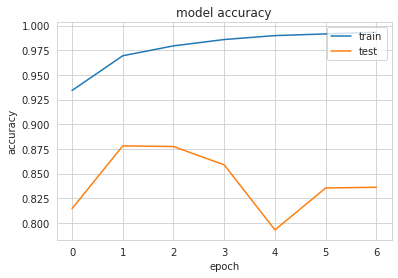

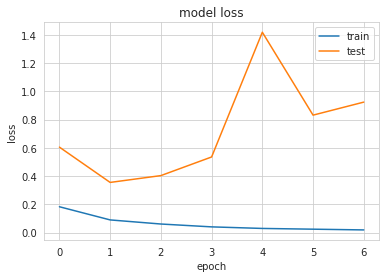

In [29]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Import modules
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

In [31]:
#Predict on test set
predictions_NN_prob = best_model.predict(test_pipeline)
print(predictions_NN_prob)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0, 1) #Turn probability to 0-1 binary output

[[9.8592025e-01 1.4079769e-02]
 [1.8029266e-05 9.9998200e-01]
 [1.7347085e-06 9.9999821e-01]
 ...
 [9.9975759e-01 2.4245329e-04]
 [2.9147327e-01 7.0852673e-01]
 [9.9799865e-01 2.0013514e-03]]


[0 0 1 ... 0 0 1]


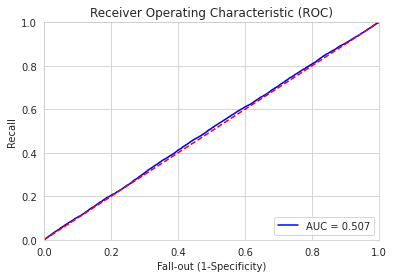

In [32]:
#Print Area Under Curve
y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])
print(test_y)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

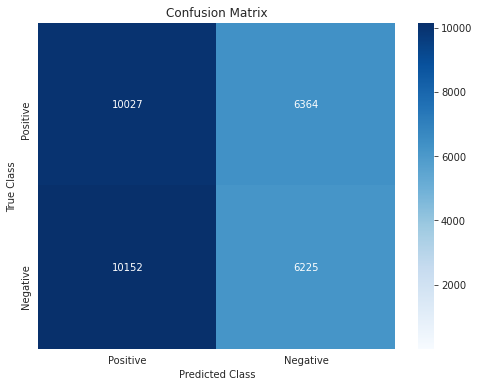

In [33]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Positive', 'Negative']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()